# Capstone Project - Machine Learning and Sentiment Analysis

Sentiment analysis is a natural language processing problem where text is understood and the underlying intent is predicted. 

In this project we will predict the sentiment of movie reviews as either positive or negative in Python using the Keras deep learning library.  

The dataset that we will be using is the Large Movie Review Dataset often referred to as the IMDB dataset. It contains 25,000 highly polar moving reviews (good or bad) for training and the same amount again for testing. The problem is to determine whether a given moving review has a positive or negative sentiment.

The data was collected by Stanford researchers and was used in a 2011 paper where a split of 50/50 of the data was used for training and test. An accuracy of 88.89% was achieved.

We will go through a series of steps to create a machine learning model, and lastly to create an application where a user can input a review, and the model will predict whether it is positive or negative.

Here are the steps we will follow: 

1. Get the dataset<br/>
2. Preprocessing the Data<br/>
3. Build the Model<br/>
4. Train the model<br/>
5. Test the Model<br/>
6. Predict Something<br/>


### 1. Get the dataset

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import re
from keras.preprocessing.text import Tokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

Using TensorFlow backend.


In [2]:
# Load the dataset using keras datasets
(X_train, y_train), (X_test, y_test) = imdb.load_data()
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)
print(X[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


The words have been replaced by integers that indicate the absolute popularity of the word in the dataset. The sentences in each review are therefore comprised of a sequence of integers.

Let's take a quick look at a few aspects of our dataset.

In [3]:
# Dataset size
print("Dataset size ")
print(f'Reviews: {X.shape[0]}')
print(f'Labels: {y.shape[0]}')

Dataset size 
Reviews: 50000
Labels: 50000


We can see that there are 50000 reviews with their corresponding labels. 

In [4]:
# Number of classes
print("Classes: ")
print(np.unique(y))

Classes: 
[0 1]


The label is represented as an integer, 0 for negative, 1 for positive.

In [5]:
# Total number of unique words
print("Number of unique words: ")
print(len(np.unique(np.hstack(X))))

Number of unique words: 
88585


The entire dataset contains nearly 90000 words. As the integers that have replaced the words are in order of popularity, we will be able to cut down considerably on the number of words on which we train the model.

Review length: 
Mean 234.76 
Standard deviation 172.91


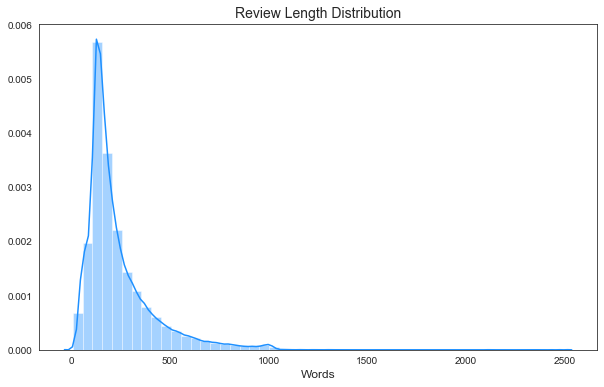

In [6]:
# Review lengths
print("Review length: ")
result = [len(x) for x in X]
result_mean = np.mean(result)
result_std = np.std(result)
print(f'Mean {result_mean:.2f} \nStandard deviation {result_std:.2f}')

# Plot review lengths
sns.set_style("white")
plt.figure(figsize=(10,6))
sns.distplot(result, color="dodgerblue")
plt.title('Review Length Distribution', fontsize=14)
plt.xlabel('Words', fontsize=12)
plt.show()

The average length for the reviews are 235 words long. As we can see from the distribution graph, most of the reviews fall under the 500 word length. In order to get a good sense of the reviews from the dataset as a whole, we will set our standard review length to 500 words.

### 2. Preprocessing the Data

In [7]:
## Preprocess the data

# load the dataset but only keep the top 5000 words
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words,
                                                      skip_top=50, # Skip the top 50 common words (e.g. 'the', 'is', 'and')
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2)

# Use pad_sequences to pad or truncate reviews to 500 words
max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

### 3. Build the Model

Word embedding is a technique where words are encoded as real-valued vectors in a high-dimensional space, where the similarity between words in terms of meaning translates to closeness in the vector space. Keras provides a convenient way to convert positive integer representations of words into a word embedding by an Embedding layer.

We will create a Recurrent Neural Network model using LSTM (Long Short-Term Memory) layers, and then a dense hidden layer of 250 neurons. The output layer has one neuron and will use a sigmoid activation to output values of 0 and 1 as predictions.

In [8]:
# Create the model
model = Sequential()

# Add layers
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 64)           16640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               8000250   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 251       
Total params: 8,177,141
Trainable params: 8,177,141
Non-trainable params: 0
____________________________________________

### 4. Train the model

We will use a 80/20 split for training and validation on the training data.

In [9]:
# Fit the model
num_epochs = 5
batch = 128
model.fit(X_train, 
          y_train, 
          validation_split=0.2, 
          epochs=num_epochs, 
          batch_size=batch, 
          verbose=1)

C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 147s 7ms/step - loss: 0.4237 - accuracy: 0.7786 - val_loss: 0.3025 - val_accuracy: 0.8738
Epoch 2/5
20000/20000 [==============================] - 142s 7ms/step - loss: 0.2226 - accuracy: 0.9124 - val_loss: 0.3284 - val_accuracy: 0.8618
Epoch 3/5
20000/20000 [==============================] - 144s 7ms/step - loss: 0.1409 - accuracy: 0.9489 - val_loss: 0.4424 - val_accuracy: 0.8374
Epoch 4/5
20000/20000 [==============================] - 142s 7ms/step - loss: 0.0626 - accuracy: 0.9807 - val_loss: 0.4969 - val_accuracy: 0.8620
Epoch 5/5
20000/20000 [==============================] - 142s 7ms/step - loss: 0.0192 - accuracy: 0.9944 - val_loss: 0.6042 - val_accuracy: 0.8582


### 5. Test the Model

We will now test the accuracy of the model by using the 25000 testing samples.

In [10]:
scores = model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy: {scores[1]*100:.2f}%')

Accuracy: 85.33%


### 6. Applying the Model

We will create a basic function for applying the model to predict the sentiment of any new reviews that a user may want to input to the model. The user's input will need to be put through a few Natural Language Processing steps before getting to the model in order for the correct input format to be achieved.

In [11]:
# Define a function for NLP steps
stop_words = set(stopwords.words('english')) 
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    clean = re.sub(r'[^\w\s]','',text, re.UNICODE)
    clean = clean.lower()
    clean = [lemmatizer.lemmatize(token) for token in clean.split(" ")]
    clean = [lemmatizer.lemmatize(token, "v") for token in clean]
    clean = [word for word in clean if not word in stop_words]
    return clean

In [12]:
# Define a function to replace the words with integers using the same imdb index
def word_integers(text):
    word_index = imdb.get_word_index()
    ints = []
    for i in text:
        try:
            word = word_index[i]
            if word > top_words: # If the word is outside of our 10000 word vocabulary, it will be ignored
                ints.append(2)
            else:
                ints.append(word_index[i])
        except KeyError:
            ints.append(2) # If the word is unrecognisable, like an unusual name, it will be ignored
            continue
    ints = np.array([ints,[]]) # Extra empty list added to create an array of lists, will be remove in a later step
    return ints

In [13]:
# Define a function to use pad_sequences to achieve the correct input length of 500 words
def review_padding(review, max_length):
    length = max_length
    padded = sequence.pad_sequences(review, maxlen=length)
    return padded

In [39]:
# Define a function that takes a review as input, then predicts the sentiment as positive or negative
def review_predict(review):
    # Input should be in string format
    pred = clean_text(review)
    pred = word_integers(pred)
    pred = review_padding(pred, max_words)
    pred = np.delete(pred, 1 ,axis=0) # Removes the extra empty list
    pred = model.predict(pred)
    if pred > 0.5:
        result = f'Positive Review {pred[0].round(2)}'
    else:
        result = f'Negative Review {pred[0].round(2)}'
    return result

In [15]:
# Example input - 10 star and 1 star user reviews for the film The Invisible Man (2020) from imdb.com
good_review = "In your average horror movie I am continuously scanning the background, but in Leigh Whannell's adaptation of The Invisible Man the horror is right behind you. You just cannot see it. The film is part of the Universal Dark Universe franchise, but reimagined by Leigh. Elisabeth Moss creeps around the gorgeous house, great production design by Alex Holmes, we are led to believe she has drugged her wealthy boyfriend Adrian played by Emerald City's Lucas; Oliver Jackson-Cohen. And in those few moments you could cut the tension with a knife. Barely escaping from this gilded prison with her sister's help, Cecilia finds refuge with her friend James and his daughter Sydney, but always feels someone is watching her. Attempting to beat her agoraphobia she eventually makes it out of the door to the mail box. A small victory. But when Adrian commits suicide, Cecilia's fears are over. With her and Harriet Dyer's sister Emily both amazed when he leaves $5 million to Cecilia, with a few unlikely codicils. But Adrian's lawyer Tom, his own brother, played by For All Mankind's Michael Dorman, assures her everything is fine. And it is. Using Adrian's $10,000 a month will allowance Cecilia sets up a Parsons College fund for Sydney, Storm Reid playing thecool daughter of Aldis Hodge's policeman James. And Cecelia feeling confident enough to work again, but why are her architectural drawings suddenly gone from her case during her interview?, and why is Diazepam suddenly on the bathroom counter?, the same medicine she used to drug Adrian, as she passes out. The hospital results show she had high levels of the Diazepam in her blood. She never took the pills. But Cecilia starts to wonder what if tech billionaire Adrian isn't actually dead, what if he created a way to make himself invisible? Could the man who abused her while he was alive, still be psychologically, and worse, terrorising her in his 'death'? We can see the duvet slipping off the bed, we know someone's there, as the photo is taken, but we cannot see him. Maybe just a foot outline on a sheet. I don't know HG Wells's The Invisible Man, other than there was a series with David McCallum when I was a kid. But Leigh Whannell has created a monster who question's Cecilia's sanity and in a shocking OMG moment ultimately robs her of her family. If no one can see her tormentor, then no one can help. But Cecilia has survived worse when living with Adrian, the painful admitting to James and Emily of the awful life she had is heartbreaking. Apparently self harm scenes were cut from the UK version which would have showed even more the psychological harm he caused her. And I cannot think of a better actress to play Cecilia than Elisabeth Moss, we are willing to invest in her as the abused woman who takes the fight to her abuser. With Tom offering Cecilia a menacing option we're totally up for it. Especially as Cecilia has an ace up her sleeve in this chilling sci-fi thriller. A terrific script and big success for Blumhouse. They are really having a moment with three of their films currently in cinemas. With an impressive score by Benjamin Wallfisch and haunting cinematography by Stefan Duscio that together builds up the suspense. As a horror fan this was superb from Leigh Whannell. The loft scenes were fantastic but it isn't relying only on the jumpy moments. Far too sophisticated a piece of work for that. Well done to the cast and crew."
bad_review = "You knew this movie would be horrible as soon as you see the opening credits CGI-ed into the water... HORRIBLE. CinemaSins is going to destroy this thing. Invisible plot holes. Invisible acting skills. Invisible suspense... invisible bank account after everything is done. The main actress (Elisabeth Moss) is seriously a horrible actress. Horrible. And she distracts you from being able to focus on the movie. She overacts every single thing. If she jumps from a sound she exaggerates it by 10x. If she looks over her shoulder to see if someone is following her she exaggerates it by 10x. I honestly am having a hard time even watching her face because it is so ugh. From the first scene the exposition is that of a first-year film student. How do you know she drugged him? She picks up the bottle of pills and shows it to you. But that isn't enough... no no, she also needs to pick up the glass of water and swirl it so you know it is in the bottle. Then she needs to say his name out loud so that he doesn't move. Then she needs to read the bottle again. Over and over. Why is this dude's research lab connected to the garage? Because the movie needs it to be. How did the dog get into the garage? Because the movie needs him there. Why in God's name did the sister stop the car to pick up the main character and then just sit there and not move?? She saw the man running towards the window and just sat there. You know she already knew that her sister was being abused, but she acted like she did not understand why she was picking up her sister in the woods in the middle of the night. Then she continued to sit there while the guy busted out the window like Superman. Am I spoiling the movie? NOPE. Why? Because all of this is in the trailer. Watch the trailer and you will know how horrible this movie is, because the trailer shows every single thing that happens in a linear fashion. Who greenlit this crap???? This movie is the reason why you do not let the director of Insidious 3 write a screenplay for a 100 year old franchise and then direct it, like he has free reign to do whatever tf he wants. I'm sorry, but they need to bring Harvey Weinstein back to Hollywood because the crap that is being churned out is WACK."

In [40]:
# Run the predictions and print the results
good = review_predict(good_review)
bad = review_predict(bad_review)
print(f'Prediction for a 10 star review: {good}')
print(f'Prediction for a 1 star review: {bad}')

Prediction for a 10 star review: Positive Review [0.74]
Prediction for a 1 star review: Negative Review [0.]


As we can see, the model has successfully predicted the sentiment of these 2 film reviews. A user would be able to input their own review and see how the model predicts the sentiment.